In [9]:
pip install pandas torch transformers scikit-learn numpy matplotlib

  Using cached regex-2024.11.6-cp313-cp313-win_amd64.whl.metadata (41 kB)
  Using cached tokenizers-0.21.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.5.3-cp38-abi3-win_amd64.whl.metadata (3.9 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
   ---------------------------------------- 0.0/10.5 MB ? eta -:--:--
   -- ------------------------------------- 0.5/10.5 MB 2.3 MB/s eta 0:00:05
   --- ------------------------------------ 0.8/10.5 MB 2.1 MB/s eta 0:00:05
   ----- ---------------------------------- 1.3/10.5 MB 2.2 MB/s eta 0:00:05
   ------ --------------------------------- 1.6/10.5 MB 2.1 MB/s eta 0:00:05
   -------- ------------------------------- 2.1/10.5 MB 2.0 MB/s eta 0:00:05
   --------- ------------------------------ 2.4/10.5 MB 2.0 MB/s eta 0:00:05
   ---------- ----------------------------- 2.6/10.5 MB 1.9 MB/s eta 0:00:05
   ----------- ---------------------------- 2.9/10.5 MB 1.8 MB/s eta 0:00:05
   ------------- ------------


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
import pandas as pd
import re
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt


Matplotlib is building the font cache; this may take a moment.


In [20]:
def clean_tweet(text):
    """Bersihkan tweet dari URL, mention, hashtag, emoji, dan karakter khusus."""
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)  # Hapus URL
    text = re.sub(r"@\w+", "", text)  # Hapus mention
    text = re.sub(r"#\w+", "", text)  # Hapus hashtag
    text = re.sub(r"[^\w\s]", "", text)  # Hapus tanda baca
    text = re.sub(r"\d+", "", text)  # Hapus angka
    text = text.lower().strip()  # Ubah ke huruf kecil dan hapus spasi berlebih
    return text

In [21]:
# --- Fungsi untuk Mendapatkan Embedding IndoBERT ---
def get_indobert_embedding(text, tokenizer, model, device):
    """Menghasilkan embedding IndoBERT untuk teks."""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].cpu().numpy()  # Ambil [CLS] token embedding


In [22]:
# --- Fungsi untuk Klasifikasi Tweet ---
def classify_tweet(tweet, stress_phrases, non_stress_phrases, tokenizer, model, device):
    """Klasifikasi tweet berdasarkan kemiripan dengan frasa stres/tidak stres."""
    cleaned_tweet = clean_tweet(tweet)
    if not cleaned_tweet:
        return "tidak_stres", 0.0  # Default jika tweet kosong setelah pembersihan

    # Dapatkan embedding tweet
    tweet_embedding = get_indobert_embedding(cleaned_tweet, tokenizer, model, device)

    # Dapatkan embedding frasa stres dan tidak stres
    stress_embeddings = [get_indobert_embedding(phrase, tokenizer, model, device) for phrase in stress_phrases]
    non_stress_embeddings = [get_indobert_embedding(phrase, tokenizer, model, device) for phrase in non_stress_phrases]

    # Hitung cosine similarity
    stress_similarities = [cosine_similarity(tweet_embedding, emb)[0][0] for emb in stress_embeddings]
    non_stress_similarities = [cosine_similarity(tweet_embedding, emb)[0][0] for emb in non_stress_embeddings]

    # Ambil similarity maksimum
    max_stress_sim = max(stress_similarities) if stress_similarities else 0
    max_non_stress_sim = max(non_stress_similarities) if non_stress_similarities else 0

    # Tentukan label berdasarkan similarity tertinggi
    if max_stress_sim > max_non_stress_sim:
        return "stres", max_stress_sim
    else:
        return "tidak_stres", max_non_stress_sim

In [23]:
# --- Setup IndoBERT ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = AutoModel.from_pretrained("indobenchmark/indobert-base-p1").to(device)

In [24]:
# Load the dataset
df_stress = pd.read_csv("dataset/real_dataset_stress.csv")

# Filter stress and non-stress phrases
stress_phrases = df_stress[df_stress["kategori"] == "stres"]["text"].tolist()
non_stress_phrases = df_stress[df_stress["kategori"] == "tidak_stres"]["text"].tolist()
df_stress.head(10)

,text,kategori
0,kepalaku penuh sama pura-pura kuat dan harapan...,stres
1,kenapa harus berusaha waktu kesepian,stres
2,kenapa harus ngerjain tugas waktu tekanan hidup,stres
3,kepalaku penuh sama menghindar dan deadline tugas,stres
4,capek banget jadi orang yang selalu tidur,stres
5,tiap malam cuma bisa memuaskan orang lain kare...,stres
6,rasanya pengen berpikir pas lagi masalah keluarga,stres
7,beneran gak kuat lagi buat menghindar,stres
8,kepalaku penuh sama diam dan omongan orang,stres
9,udah nangis tapi tetap harapan palsu,stres


In [29]:
# --- Load Tweet dari CSV ---
file_path = "tweets-data/stress_tweets.csv"
df_tweets = pd.read_csv(file_path)
df_tweets.head(10)

,conversation_id_str,created_at,favorite_count,full_text,id_str,image_url,in_reply_to_screen_name,lang,location,quote_count,reply_count,retweet_count,tweet_url,user_id_str,username
0,1926197518993326292,Sat May 24 08:44:10 +0000 2025,0,Growtopia membuat saya ingin bunuh diri,1926197518993326292,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/192619751899332...,1915962316820275200,NaN
1,1926083923114643472,Sat May 24 01:12:46 +0000 2025,0,Dimasak ekonomi,1926083923114643472,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/192608392311464...,1915962316820275200,NaN
2,1926062701999976702,Fri May 23 23:48:27 +0000 2025,0,Kepala saya sakit,1926062701999976702,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/192606270199997...,1915962316820275200,NaN
3,1924292769830650037,Mon May 19 02:35:22 +0000 2025,0,Yh gwe terakhiran keluar pas mtk tp gpp ttp be...,1924292769830650037,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/192429276983065...,1915962316820275200,NaN
4,1922964794211959081,Thu May 15 10:38:28 +0000 2025,0,Habis mandi tuh berasa suci,1922964794211959081,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/192296479421195...,1915962316820275200,NaN
5,1922691545192411593,Wed May 14 16:32:40 +0000 2025,0,SWEET INSOMNIA,1922691545192411593,NaN,NaN,en,NaN,0,0,0,https://x.com/undefined/status/192269154519241...,1915962316820275200,NaN
6,1922691509620449559,Wed May 14 16:32:32 +0000 2025,0,Insomnia,1922691509620449559,NaN,NaN,en,NaN,0,0,0,https://x.com/undefined/status/192269150962044...,1915962316820275200,NaN
7,1922691481980068246,Wed May 14 16:32:25 +0000 2025,0,Gabisa tidur,1922691481980068246,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/192269148198006...,1915962316820275200,NaN
8,1922246836888240371,Tue May 13 11:05:34 +0000 2025,0,Mau bulking tapi malah takut jd fatty,1922246836888240371,NaN,NaN,in,NaN,0,0,0,https://x.com/undefined/status/192224683688824...,1915962316820275200,NaN
9,1922246549695812054,Tue May 13 11:04:25 +0000 2025,0,PUSING BANGET PLS,1922246549695812054,NaN,NaN,en,NaN,0,0,0,https://x.com/undefined/status/192224654969581...,1915962316820275200,NaN


In [30]:
# --- Klasifikasi Tweet ---
results = []
for _, row in df_tweets.iterrows():
    tweet = row["full_text"]
    label, similarity = classify_tweet(tweet, stress_phrases, non_stress_phrases, tokenizer, model, device)
    results.append({
        "text": tweet,
        "cleaned_text": clean_tweet(tweet),
        "label": label,
        "similarity_score": similarity,
        "created_at": row["created_at"],
        "user_id": row["user_id_str"]
    })

In [31]:
# Buat DataFrame dan simpan ke CSV
df_results = pd.DataFrame(results)
df_results.to_csv("tweet_stress_classification_results.csv", index=False)

In [32]:
# --- Hitung Kesimpulan Akhir ---
stress_count = len(df_results[df_results["label"] == "stres"])
total_tweets = len(df_results)
stress_percentage = (stress_count / total_tweets) * 100 if total_tweets > 0 else 0

In [33]:
# Tentukan kesimpulan
final_conclusion = "Stres" if stress_percentage >= 50 else "Tidak Stres"

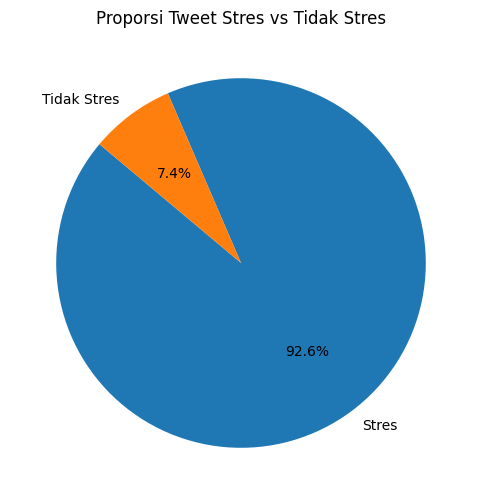

In [34]:
# --- Visualisasi Pie Chart ---
labels = ["Stres", "Tidak Stres"]
sizes = [stress_count, total_tweets - stress_count]
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=140)
plt.title("Proporsi Tweet Stres vs Tidak Stres")
plt.savefig("stress_pie_chart.png")
plt.show()

In [35]:
# --- Tampilkan Hasil ---
print(f"\nHasil Analisis Stres dari {total_tweets} Tweet:")
print(f"Jumlah Tweet Stres: {stress_count} ({stress_percentage:.2f}%)")
print(f"Jumlah Tweet Tidak Stres: {total_tweets - stress_count} ({100 - stress_percentage:.2f}%)")
print(f"Kesimpulan Akhir: {final_conclusion}")


Hasil Analisis Stres dari 27 Tweet:
Jumlah Tweet Stres: 25 (92.59%)
Jumlah Tweet Tidak Stres: 2 (7.41%)
Kesimpulan Akhir: Stres


In [36]:
df_results['clean_text'] = df_results['text'].apply(clean_tweet)

# Tampilkan semua hasil klasifikasi tweet stress
print("\nContoh Hasil Klasifikasi (Semua):")
for i, row in df_results.iterrows():
    print(f"Tweet: {row['clean_text']}")
    print(f"Label: {row['label']} (Similarity: {row['similarity_score']:.4f})")
    print("-" * 50)



Contoh Hasil Klasifikasi (Semua):
Tweet: growtopia membuat saya ingin bunuh diri
Label: stres (Similarity: 0.9381)
--------------------------------------------------
Tweet: dimasak ekonomi
Label: stres (Similarity: 0.7144)
--------------------------------------------------
Tweet: kepala saya sakit
Label: stres (Similarity: 0.8608)
--------------------------------------------------
Tweet: yh gwe terakhiran keluar pas mtk tp gpp ttp berserah diri kepada tuhan dn berusaha
Label: stres (Similarity: 0.8820)
--------------------------------------------------
Tweet: habis mandi tuh berasa suci
Label: stres (Similarity: 0.9020)
--------------------------------------------------
Tweet: sweet insomnia
Label: stres (Similarity: 0.6787)
--------------------------------------------------
Tweet: insomnia
Label: stres (Similarity: 0.7565)
--------------------------------------------------
Tweet: gabisa tidur
Label: stres (Similarity: 0.8306)
--------------------------------------------------
Tweet: 

In [ ]:
import json
with open('hasil.json', 'w', encoding='utf-8') as f:
    json.dump(hasil_akhir, f, ensure_ascii=False)
